# Spots classifier

In [1]:
import torch
torch.cuda.is_available()

False

In [2]:
import numpy as np
import numpy.typing as npt

import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

import matplotlib.pyplot as plt
import torch.nn.functional as func
from tqdm.notebook import tqdm
from PIL import Image
import gc
import torch.optim as optim

import os,sys
try:
    import this_is_root
except:
    os.chdir(os.path.pardir) # change workdir to be root dir
    sys.path.insert(0, os.path.realpath("."))

import create_training_data.training_data_generator

torch.cuda.is_available()
np.random.seed(0)

c:\Users\talbarka.WISMAIN\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
c:\Users\talbarka.WISMAIN\Anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
imgs_generator = create_training_data.training_data_generator.ClassifierTrainingDataGenerator.make_default_training_data_generator(batch_size=1000)
TAG = 1
IMG = 0

-1.0


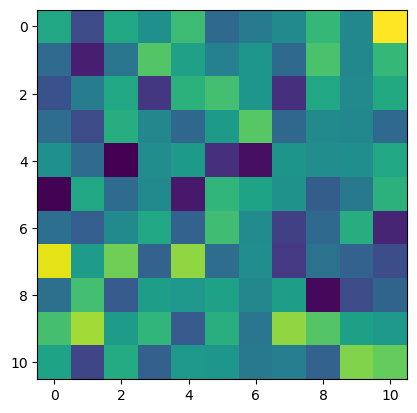

In [4]:
imgs= imgs_generator.get_next_batch()
idx = 36
print(imgs[TAG][idx])
# imgs[IMG][idx]
plt.imshow(imgs[IMG][idx][:,:,1,1])

In [5]:
len(imgs)
# len(imgs[0])
# imgs[0][0].shape

2

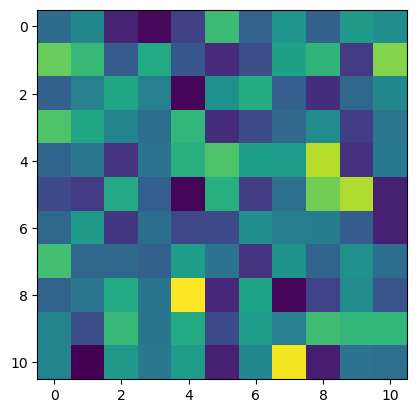

In [6]:
plt.imshow(imgs[0][0][:,:,1,1])

In [7]:
# CREATE FAKE IMAGES
# spots_count = 30
# fake_img_shape = (11,11,10,3)
# spots = []
# spots_classes = []
# for ii in range(spots_count):
#     spots.append(np.random.rand(*fake_img_shape))
#     spots_classes.append(np.round(np.random.rand()))

# plt.imshow(spots[1][:,:,1,1])

In [8]:
TEST_SIZE = 0.3
train_img, val_img, train_label, val_label = train_test_split(imgs[IMG], imgs[TAG], test_size=TEST_SIZE, random_state=0)

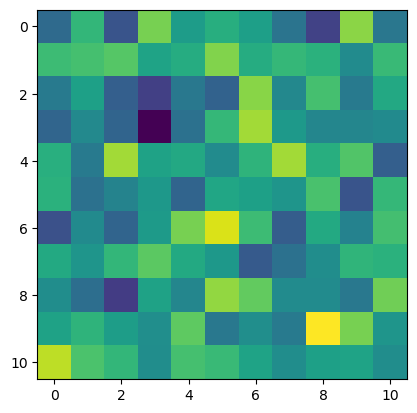

In [9]:
idx=9
plt.imshow(train_img[idx][:,:,1,1])
# plt.imshow(np.max(train_img[idx][IMG][:,:,1,:],axis=2))

In [10]:
class MyDataset(Dataset):
    def __init__(self, img_array, label_array):
        # convert to tensor
        self.img_array   = img_array
        self.label_array = label_array

    def __len__(self):
        return len(self.label_array)

    def __getitem__(self, idx):
        img   = torch.tensor(self.img_array[idx].copy()).float()
        img = img.permute(3, 2, 1, 0)
        label = torch.tensor(self.label_array[idx])
        return img, label

In [11]:
train_ds = MyDataset(train_img, train_label)
# del train_img; del train_label
# gc.collect()

val_ds   = MyDataset(val_img, val_label)
# del val_img; del val_label
# gc.collect()

In [12]:
np.unique(train_label)

array([-1.,  1.,  2.,  3.])

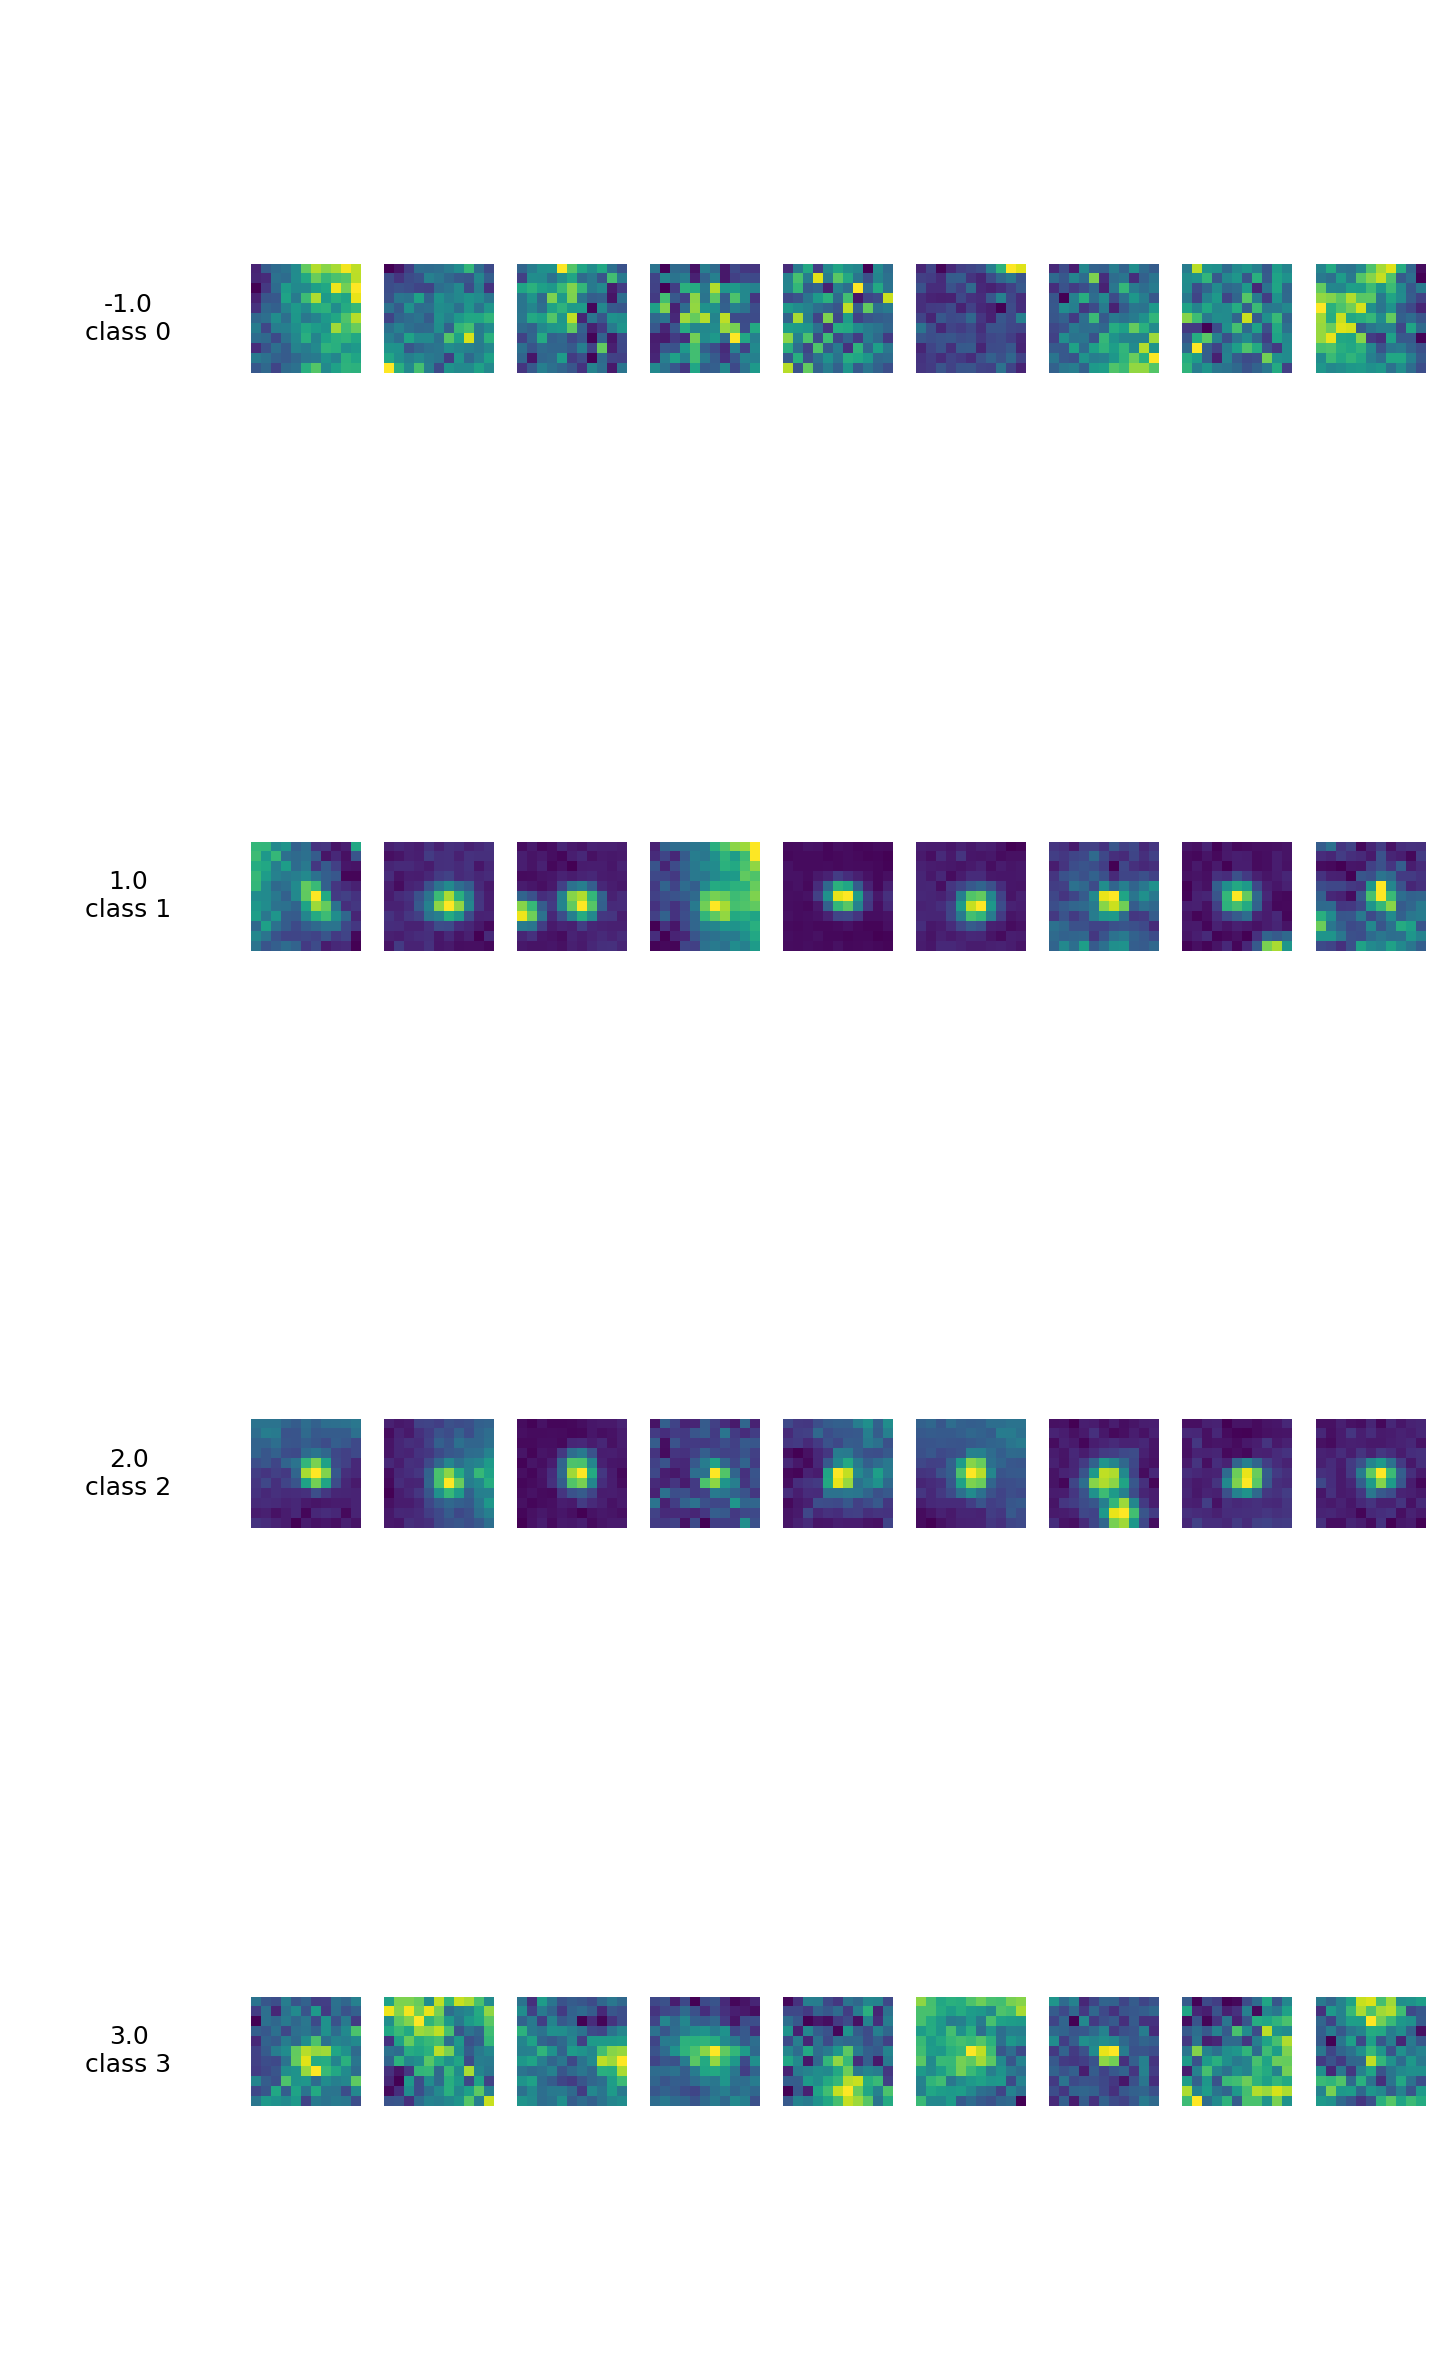

In [13]:
class_labels = np.unique(train_label)

fig = plt.figure(figsize=(6,10), dpi=300)

nrow, ncol = len(class_labels), 10
gs = GridSpec(nrow, ncol, hspace=0.0, width_ratios=[1.8,1,1,1,1,1,1,1,1,1])

for cl_idx, my_class in enumerate(class_labels):
    
    idxs = np.where(np.array(train_label)==my_class)[0]
    ax = fig.add_subplot(gs[cl_idx*ncol])

    center_x = (ax.get_xlim()[1] - ax.get_xlim()[0]) / 2
    center_y = (ax.get_ylim()[1] - ax.get_ylim()[0]) / 2

    ax.text(center_x, center_y, str(class_labels[cl_idx]) + f'\nclass {cl_idx}', ha='center', va='center', fontsize=6)
    ax.axis("off")

    for j in range(1, ncol):
        ax = fig.add_subplot(gs[cl_idx*ncol + j])
        ax.imshow(np.max(train_img[idxs[j-1]][:,:,:,np.max(int(my_class)-1,0)],axis=2))
        ax.axis("off")

In [14]:
def get_loss_accuracy(model, dataloader):
    losses = []
    correct_count, total_count = 0, 0
    with torch.no_grad():
        for xb, yb in dataloader:
            if torch.cuda.is_available():
                xb = xb.cuda()
                yb = yb.cuda()
            ypred = model(xb)

            loss = nn.CrossEntropyLoss(reduction='none')(ypred, yb)
            losses.extend(loss.tolist())
            
            ypred = ypred.argmax(dim=1)
            correct_count += (ypred == yb).sum().item()
            total_count += ypred.size(0)

    return np.mean(losses), correct_count/total_count

### Import the CNN model

In [15]:
from model_classifier import spots_classifier_net

In [16]:
net = spots_classifier_net()

In [17]:
dl_batch_size = 16
train_dl = DataLoader(train_ds, batch_size=dl_batch_size, shuffle=True)
valid_dl = DataLoader(val_ds, batch_size=dl_batch_size, shuffle=True)

### The training loop

In [35]:
def train_valid_loop(net, valid_dl, Nepochs, learning_rate=0.001, batch_size=100, save_model_interval=1500):
    imgs_generator = create_training_data.training_data_generator.ClassifierTrainingDataGenerator.make_default_training_data_generator(batch_size=batch_size)
    TAG = 1
    IMG = 0
    imgs = imgs_generator.get_next_batch()
    train_img, train_label = imgs[IMG], imgs[TAG]

    train_ds = MyDataset(train_img, train_label)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)



    train_loss = []
    valid_loss = []

    ### Optimizer
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)# use Adam

    ### Check for GPU
    device = torch.device("cpu")
    if torch.cuda.is_available():
        print('Found GPU!')
        device = torch.device("cuda:0")

    net.to(device) # put it on the device

    for epoch in tqdm(range(Nepochs)):# loop over Nepochs
        ### Training
        net.train()

        xb,yb = next(iter(train_dl))#which dataloader?
        xb = xb.to(device)
        yb = yb.to(device)
        
        optimizer.zero_grad()#...please make sure the gradients are zeroed-out each time!

        pred = net(xb)#pass the input through the net to get the prediction
        loss = func.cross_entropy(pred,yb)#use the MSE loss between the prediction and the target
        # --> <-- ADD LINE TO DO BACKPROPAGATION HERE ::: DONE! next line
        loss.backward()
        optimizer.step()#...please make the optimizer step in the direction of negative gradient

        ### take the average of the loss over each batch and append it to the list
        train_loss.append(loss.item())

        ### Validation
        net.eval()

        valid_loss_epoch = []
        for xb,yb in tqdm(valid_dl):#which dataloader?
            xb = xb.to(device)# move the validation input to the device
            yb = yb.to(device)# move the validation target to the device
            pred = net(xb)# same as in training loop
            loss = func.cross_entropy(pred,yb)# same as in training loop
            valid_loss_epoch.append(loss.item())

        valid_loss.append(np.mean(valid_loss_epoch))

        ### Model checkpointing
        if np.mod(epoch,save_model_interval) == 0:
            torch.save(net.state_dict(),'epoch'+str(epoch)+'saved_model.pt')
        if epoch > 0:
            if valid_loss[-1] < min(valid_loss[:-1]):
                torch.save(net.state_dict(), 'final_saved_model.pt')

        print('Epoch: ',epoch,' Train loss: ',train_loss[-1],' Valid loss: ',valid_loss[-1])

    #Bring net back to CPU
    net.cpu()

    return train_loss, valid_loss

In [36]:
np.random.seed(0)
train_loss, valid_loss = train_valid_loop(net, valid_dl, batch_size=2000, Nepochs=40, learning_rate=1e-3)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch:  0  Train loss:  7683.96875  Valid loss:  24.0072458668759


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch:  1  Train loss:  7683.43115234375  Valid loss:  23.85519323850933


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch:  2  Train loss:  7683.18505859375  Valid loss:  23.91688673119796


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch:  3  Train loss:  7682.81396484375  Valid loss:  23.9132668595565


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch:  4  Train loss:  7682.90771484375  Valid loss:  24.039203882217407


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch:  5  Train loss:  7682.734375  Valid loss:  23.9755987117165


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch:  6  Train loss:  7681.560546875  Valid loss:  24.072813573636505


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch:  7  Train loss:  7681.36083984375  Valid loss:  23.893420282163117


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch:  8  Train loss:  7680.8046875  Valid loss:  23.984383808939082


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch:  9  Train loss:  7680.09423828125  Valid loss:  24.03707333614952


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch:  10  Train loss:  7679.52099609375  Valid loss:  23.924633804120514


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch:  11  Train loss:  7679.498046875  Valid loss:  24.01598394544501


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch:  12  Train loss:  7679.28173828125  Valid loss:  23.97605629971153


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch:  13  Train loss:  7678.42578125  Valid loss:  23.917865828463906


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch:  14  Train loss:  7677.20947265625  Valid loss:  24.0919643452293


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch:  15  Train loss:  7676.875  Valid loss:  23.985405344712106


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch:  16  Train loss:  7674.30712890625  Valid loss:  23.951126600566663


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch:  17  Train loss:  7676.29833984375  Valid loss:  24.013413153196637


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch:  18  Train loss:  7675.7080078125  Valid loss:  24.083359655581024


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch:  19  Train loss:  7673.29833984375  Valid loss:  23.976859933451603


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch:  20  Train loss:  7675.9580078125  Valid loss:  24.09808389764083


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch:  21  Train loss:  7673.7802734375  Valid loss:  24.10494657566673


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch:  22  Train loss:  7672.6416015625  Valid loss:  24.074679575468366


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch:  23  Train loss:  7672.2431640625  Valid loss:  24.079483709837262


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch:  24  Train loss:  7675.09130859375  Valid loss:  24.099793032595986


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch:  25  Train loss:  7672.2197265625  Valid loss:  24.112060333553114


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch:  26  Train loss:  7671.05859375  Valid loss:  24.09537400697407


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch:  27  Train loss:  7673.18798828125  Valid loss:  24.039127324756823


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch:  28  Train loss:  7667.740234375  Valid loss:  24.058345493517425


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch:  29  Train loss:  7667.2109375  Valid loss:  24.048719255547773


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch:  30  Train loss:  7673.29345703125  Valid loss:  24.02240252494812


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch:  31  Train loss:  7670.09814453125  Valid loss:  24.00710984280235


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch:  32  Train loss:  7665.70361328125  Valid loss:  24.038817769602726


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch:  33  Train loss:  7666.0439453125  Valid loss:  24.021079916703073


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch:  34  Train loss:  7663.84619140625  Valid loss:  23.986982947901677


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch:  35  Train loss:  7666.03955078125  Valid loss:  23.958598538448935


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch:  36  Train loss:  7658.00244140625  Valid loss:  24.10310903348421


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch:  37  Train loss:  7659.90966796875  Valid loss:  24.29473210635938


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch:  38  Train loss:  7658.72607421875  Valid loss:  24.178548837962904


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch:  39  Train loss:  7661.9892578125  Valid loss:  24.196465115798148


### Load the best model from training

In [20]:
net.load_state_dict(torch.load('saved_model.pt',map_location=torch.device('cpu')))

<All keys matched successfully>

### Plot the training and validation losses

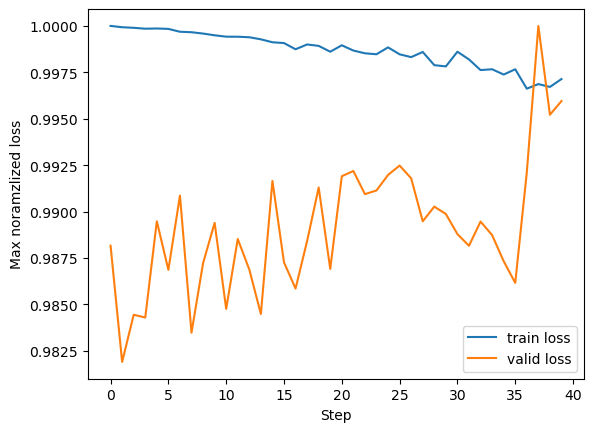

In [38]:
fig, axes = plt.subplots()
axes.plot(range(len(train_loss)),train_loss/np.max(train_loss),label='train loss')
axes.plot(range(len(valid_loss)),valid_loss/np.max(valid_loss),label='valid loss')
# axes.set_yscale('log')
axes.set_xlabel("Step")
axes.set_ylabel("Max noramzlized loss")
# axes.set_ylim([1e-2,1e0])
axes.legend()
plt.show()

### A loss below 0.015 over the full rotweiler dataset should have been reached during the training to pass the assignment

In [23]:
from evaluate_dogs import evaluate_on_dataset
total_loss = evaluate_on_dataset()
print(total_loss)

ModuleNotFoundError: No module named 'evaluate_dogs'

### Voila!

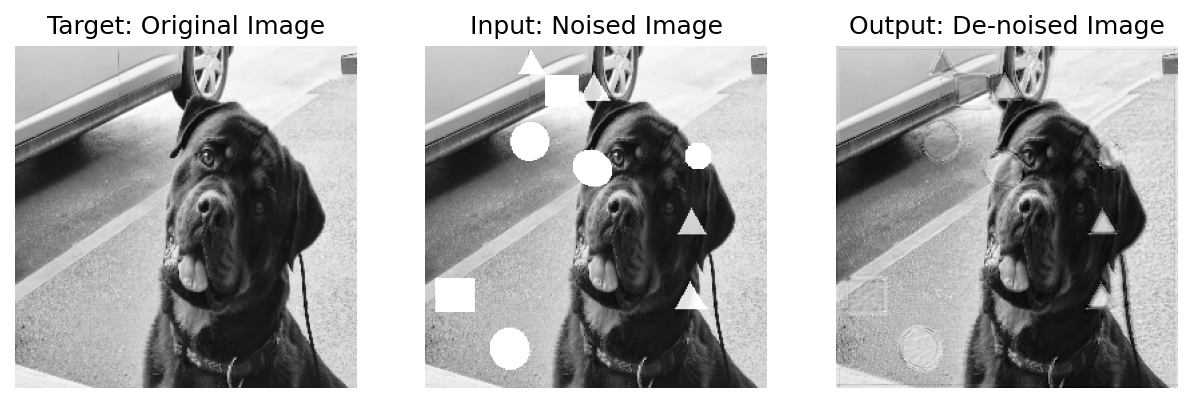

In [ ]:
x, y = valid_ds[2]

xprime = net(x.unsqueeze(0)).detach()

fig,ax = plt.subplots(1,3,figsize=(10,3),dpi=150)

ax[0].imshow(y.squeeze(0 ),cmap='Greys_r',vmin=0,vmax=1)
ax[0].set_title('Target: Original Image')
ax[1].imshow(x.squeeze(0),cmap='Greys_r',vmin=0,vmax=1)
ax[1].set_title('Input: Noised Image')
ax[2].imshow(xprime.squeeze(0,1),cmap='Greys_r',vmin=0,vmax=1)
ax[2].set_title('Output: De-noised Image')

for i in range(3):
    ax[i].set_axis_off()

plt.show()

In [ ]:
def train_valid_loop_partially_changed(net, train_dl, valid_dl, Nepochs, learning_rate=0.001, batch_size=100):
    imgs_generator = create_training_data.training_data_generator.ClassifierTrainingDataGenerator.make_default_training_data_generator(batch_size=batch_size)
    TAG = 1
    IMG = 0
    imgs = imgs_generator.get_next_batch()
    train_img, train_label = imgs[IMG], imgs[TAG]

    train_ds = MyDataset(train_img, train_label)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)



    train_loss = []
    valid_loss = []

    ### Optimizer
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)# use Adam

    ### Check for GPU
    device = torch.device("cpu")
    if torch.cuda.is_available():
        print('Found GPU!')
        device = torch.device("cuda:0")

    net.to(device) # put it on the device

    for epoch in tqdm(range(Nepochs)):# loop over Nepochs

        ### Training
        net.train()

        xb,yb = next(train_dl)#which dataloader?
        xb = xb.to(device)
        yb = yb.to(device)
        
        optimizer.zero_grad()#...please make sure the gradients are zeroed-out each time!

        pred = net(xb)#pass the input through the net to get the prediction
        loss = func.cross_entropy(pred,yb)#use the MSE loss between the prediction and the target
        # --> <-- ADD LINE TO DO BACKPROPAGATION HERE ::: DONE! next line
        loss.backward()
        optimizer.step()#...please make the optimizer step in the direction of negative gradient

        ### take the average of the loss over each batch and append it to the list
        train_loss.append(loss.item())

        ### Validation
        net.eval()

        valid_loss_epoch = []
        for xb,yb in tqdm(valid_dl):#which dataloader?
            xb = xb.to(device)# move the validation input to the device
            yb = yb.to(device)# move the validation target to the device
            pred = net(xb)# same as in training loop
            loss = func.cross_entropy(pred,yb)# same as in training loop
            valid_loss_epoch.append(loss.item())

        valid_loss.append(np.mean(valid_loss_epoch))

        ### Model checkpointing
        if epoch > 0:
            if valid_loss[-1] < min(valid_loss[:-1]):
                torch.save(net.state_dict(), 'saved_model.pt')

        print('Epoch: ',epoch,' Train loss: ',train_loss[-1],' Valid loss: ',valid_loss[-1])

    #Bring net back to CPU
    net.cpu()

    return train_loss, valid_loss